In [9]:
%pip install matplotlib
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/9.2 MB ? eta -:--:--
                                              0.2/9.2 MB 5.0 MB/s eta 0:00:02
     ---                                      0.7/9.2 MB 9.1 MB/s eta 0:00:01
     ------                                   1.5/9.2 MB 11.6 MB/s eta 0:00:01
     ---------                                2.2/9.2 MB 12.6 MB/s eta 0:00:01
     ------------                             2.9/9.2 MB 14.5 MB/s eta 0:00:01
     ---------------                          3.5/9.2 MB 14.1 MB/s eta 0:00:01
     ------------------                       4.3/9.2 MB 13.6 MB/s eta 0:00:01
     ----------------------                   5.1/9.2 MB 14.8 MB/s eta 0:00:01
     -------------------------                5.9/9.2 MB 15.2 MB/s eta 0:00:01
     -----------------------------            6.8/9.2 MB 15.0 MB/s eta 0:00:01
     ---------------------------------        7.7/9.2 MB 15.4 MB/s eta 0:00:01
     ------------------------------------     8.3/9.2 MB 15.2 


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

# Catfish Sales Data

In [11]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [15]:
#read data
catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)

C:\Users\SwaroopDamodaran\AppData\Local\Temp\ipykernel_14696\365243236.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  catfish_sales = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, date_parser=parser)


In [16]:
#infer the frequency of the data
catfish_sales = catfish_sales.asfreq(pd.infer_freq(catfish_sales.index))

In [17]:
start_date = datetime(1996,1,1)
end_date = datetime(2000,1,1)
lim_catfish_sales = catfish_sales[start_date:end_date]

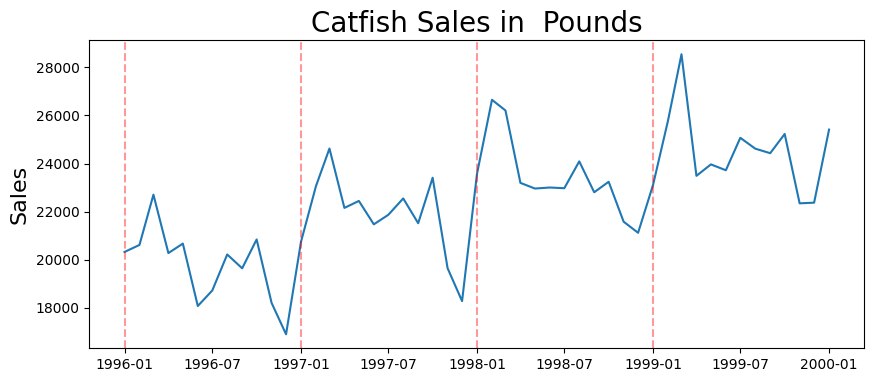

In [107]:
plt.figure(figsize=(10,4))
plt.plot(lim_catfish_sales)
plt.title('Catfish Sales in  Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='r', linestyle='--', alpha=0.4)

## Remove the trend

In [26]:
first_diff = lim_catfish_sales.diff()[1:]

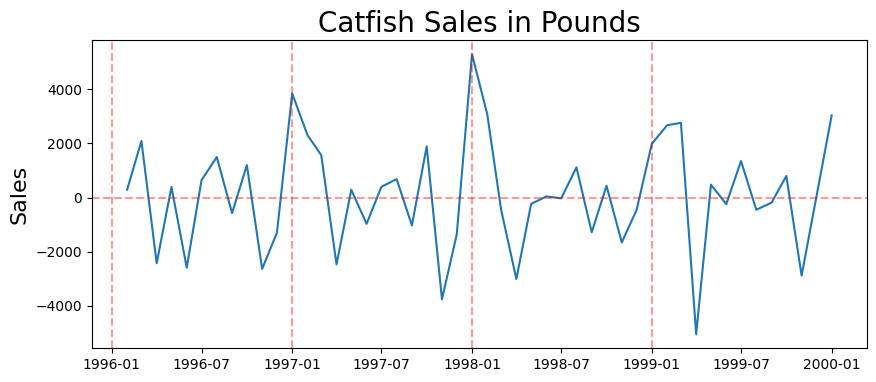

In [108]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Catfish Sales in Pounds', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='r', linestyle='--', alpha=0.4)
plt.axhline(0, color='r', linestyle='--', alpha=0.4)

# ACF

<BarContainer object of 17 artists>

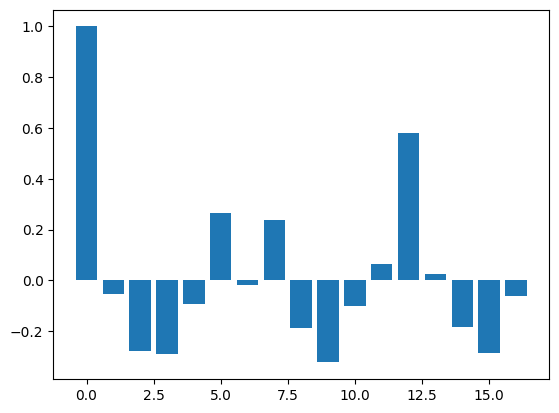

In [33]:
acf_vals = acf(first_diff)
num_lags = 17
plt.bar(range(num_lags), acf_vals[:num_lags])

## Based on ACF, we should start with a seasonal MA process

# PACF

<BarContainer object of 15 artists>

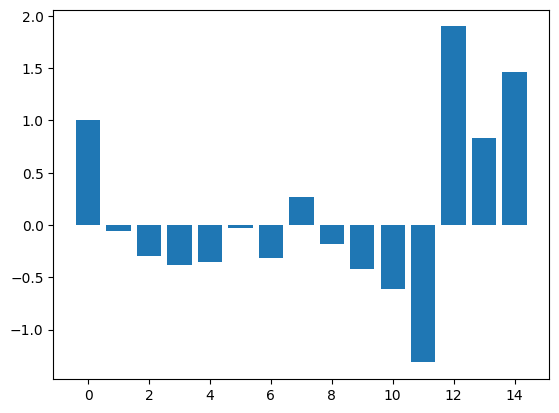

In [57]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

## Based on PACF, we should start with a seasonal AR process

# Get training and testing sets

In [58]:
train_end = datetime(1999,7,1)
test_end = datetime(2000,1,1)

train_data = lim_catfish_sales[:train_end]
test_data = lim_catfish_sales[train_end + timedelta(days=1):test_end]

# ARIMA 

In [98]:
my_order = (0,1,0)
arima_model = ARIMA(train_data, order=my_order)

In [101]:
#fit the model
start = time()
model_fit = arima_model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.01383352279663086


In [102]:
#summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                   43
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -380.363
Date:                Wed, 30 Aug 2023   AIC                            762.725
Time:                        14:44:37   BIC                            764.463
Sample:                    01-01-1996   HQIC                           763.362
                         - 07-01-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.222e+06   8.79e+05      4.803      0.000     2.5e+06    5.94e+06
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.76   Pr

In [104]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.iloc[:,0] - predictions



Text(0, 0.5, 'Error')

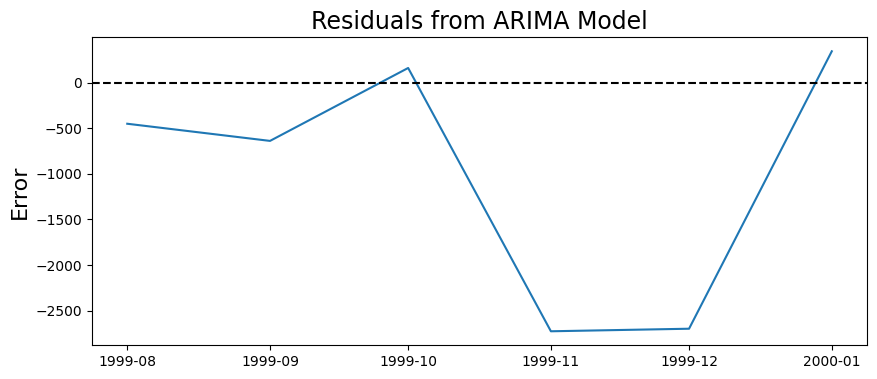

In [105]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=17)
plt.ylabel('Error', fontsize=16)

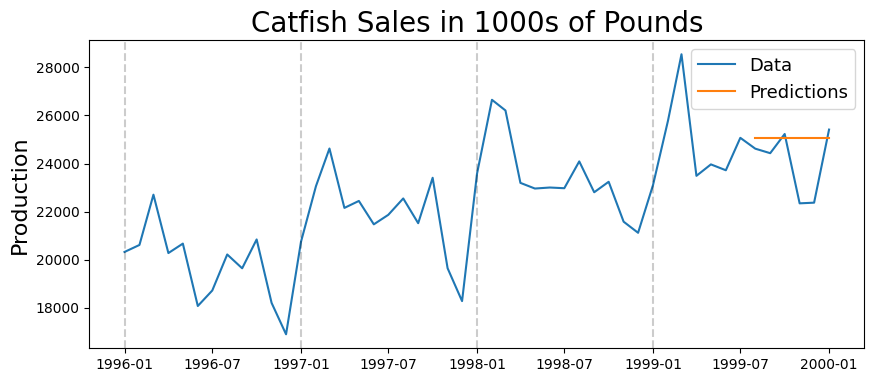

In [106]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=13)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Fit the SARIMA Model

In [59]:
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [60]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.17614269256591797


c:\Users\SwaroopDamodaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Users\SwaroopDamodaran\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [61]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Total   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -365.635
Date:                              Wed, 30 Aug 2023   AIC                            737.269
Time:                                      14:20:50   BIC                            742.482
Sample:                                  01-01-1996   HQIC                           739.180
                                       - 07-01-1999                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8250      0.120      6.847      0.000       0.589       1.061
ma.S.L12      -0.51

In [87]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data.iloc[:,0] - predictions



Date
1999-08-01   -1077.467580
1999-09-01    -624.182556
1999-10-01    -413.836899
1999-11-01   -1851.602521
1999-12-01   -1305.365019
2000-01-01    -838.513119
Freq: MS, dtype: float64


Text(0, 0.5, 'Error')

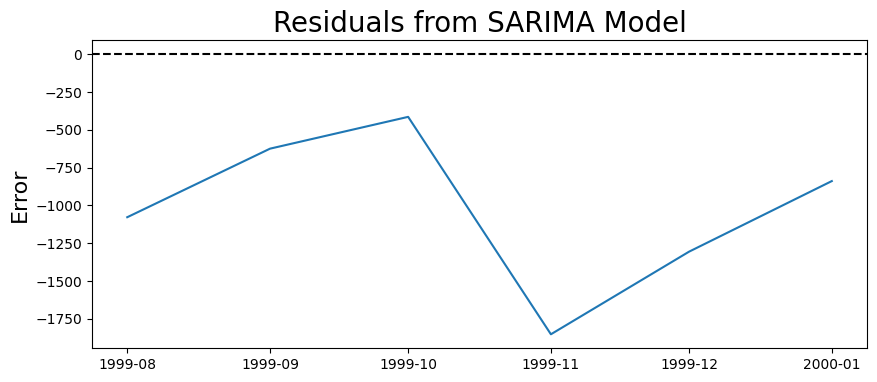

In [88]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

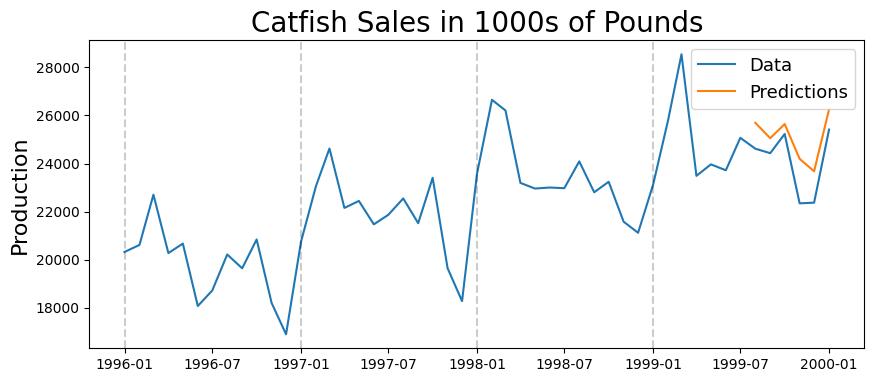

In [63]:
plt.figure(figsize=(10,4))

plt.plot(lim_catfish_sales)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=13)

plt.title('Catfish Sales in 1000s of Pounds', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [92]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/(test_data.iloc[:,0]))),4))

Mean Absolute Percent Error: 0.0433


In [90]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 1122.297881456822
